In [23]:
import pandas as pd, numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from hiveplot import HivePlot
from copy import copy

%matplotlib inline

## Read in HGNC Mapper

In [5]:
hgnc = pd.read_csv('../../data/hgnc_alias_list.txt', sep='\t')
hgnc.head()

,HGNC ID,Approved symbol,Approved name,Status,Previous symbols,Synonyms,Chromosome,Accession numbers,RefSeq IDs,NCBI Gene ID(supplied by NCBI),Ensembl ID(supplied by Ensembl),Rat genome database ID(supplied by RGD),Vega ID(supplied by Vega),OMIM ID(supplied by OMIM),RefSeq(supplied by NCBI),UCSC ID(supplied by UCSC),UniProt ID(supplied by UniProt),Mouse genome database ID(supplied by MGI),Name synonyms
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1.0,ENSG00000121410,RGD:69417,OTTHUMG00000183507,138670,NM_130786,uc002qsd.5,P04217,MGI:2152878,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538.0,ENSG00000268895,NaN,OTTHUMG00000183508,NaN,NR_015380,uc002qse.3,NaN,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974.0,ENSG00000148584,RGD:619834,OTTHUMG00000018240,618199,NM_001198818,uc057tgv.1,Q9NQ94,MGI:1917115,NaN
3,HGNC:6,A1S9T~withdrawn,"symbol withdrawn, see UBA1",Symbol Withdrawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2.0,ENSG00000175899,RGD:2004,OTTHUMG00000150267,103950,NM_000014,uc001qvk.2,P01023,MGI:2449119,NaN


In [6]:
hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


In [7]:
#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))


current_syn_list.head()

,HGNC ID,Approved symbol,Approved name,Previous symbols,variable,synonym
0,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",0,FLJ23569
1,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,0,ACF
2,HGNC:7,A2M,alpha-2-macroglobulin,NaN,0,FWP007
3,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,0,FLJ25179
4,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,0,IGBS3S


In [8]:
prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


prev_symb_list.head()

,HGNC ID,Approved symbol,Approved name,Synonyms,variable,synonym
0,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,FLJ23569,0,NCRNA00181
1,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,"FLJ25179, p170",0,CPAMD9
2,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,NaN,0,A2MP
3,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2","IGBS3S, IGB3S",0,A3GALT2P
4,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)","A14GALT, Gb3S, P(k)",0,P1


In [9]:
hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

In [10]:
trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

RAGE


In [11]:
hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196'}

In [12]:
hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

## Create Louvain clusters

In [129]:
louvain_tier2 = pd.read_csv('../../results/louvain_small_clusters.txt', sep='\t')
louv= louvain_tier1.merge(louvain_tier2.set_index('names'), how='left', on='names', suffixes=['_super', '_sub'])
louv.names = louv.names.apply(lambda x: hgnc_mapper[x])
louv.head()

,names,cluster_super,cluster_sub
0,PAK1,5,3
1,ERBB2,5,18
2,MST1R,5,18
3,YES1,5,18
4,TYRO3,5,18


## Read in the Graph for connectivity

In [131]:
graph_edges = pd.read_csv('../../data/KIN_edges_no_weights.txt', sep='\t', header=None)
graph_edges[0] = copy(graph_edges[0].apply(lambda x: hgnc_mapper[x]))
graph_edges[1] = copy(graph_edges[1].apply(lambda x: hgnc_mapper[x]))
graph_edges.head()

,0,1
0,PAK1,ERBB2
1,MST1R,YES1
2,TYRO3,YES1
3,LYN,KIT
4,PRKCA,KIT


In [132]:
graph_edges_duplicate = copy(graph_edges)
graph_edges_duplicate.columns = [1,0]
graph_edges_duplicate = graph_edges_duplicate[[0,1]]

graph_edges_extended= graph_edges.append(graph_edges_duplicate)

In [133]:
graph_edge_dict = graph_edges_extended.groupby(0).agg(lambda x: set(x)).to_dict()[1]
graph_edge_dict.update({x:y|set([x]) for x,y in graph_edge_dict.items()})# make reflexive
graph_edge_dict

{'AATK': {'AATK', 'CDK5', 'STK39'},
 'ABL1': {'ABL1',
  'ABL2',
  'ATM',
  'ATR',
  'BMP2K',
  'BTK',
  'CDK1',
  'CDK5',
  'CDKL5',
  'CLK1',
  'CLK4',
  'EGFR',
  'EPHA1',
  'EPHA3',
  'EPHA4',
  'EPHA5',
  'EPHA7',
  'EPHA8',
  'EPHB2',
  'EPHB3',
  'EPHB6',
  'ERBB2',
  'ERBB3',
  'ERBB4',
  'FYN',
  'HCK',
  'HIPK2',
  'JAK1',
  'JAK2',
  'KIT',
  'LATS2',
  'LRRK1',
  'LRRK2',
  'LYN',
  'MAP3K8',
  'MAP4K1',
  'MAP4K5',
  'MAPK1',
  'MAPK11',
  'MAPK12',
  'MAPK14',
  'MAPK3',
  'MET',
  'MTOR',
  'MYLK',
  'NEK8',
  'NTRK1',
  'NTRK2',
  'NTRK3',
  'PAK2',
  'PDGFRB',
  'PDK1',
  'PKM',
  'PRKCD',
  'PRKCZ',
  'PRKD1',
  'PRKDC',
  'ROS1',
  'SRC',
  'SRPK2',
  'STK3',
  'STK4',
  'SYK',
  'TTK',
  'UHMK1',
  'WNK2',
  'YES1',
  'ZAP70'},
 'ABL2': {'ABL1',
  'ABL2',
  'EGFR',
  'EPHB2',
  'ERBB2',
  'ERBB3',
  'ERBB4',
  'FYN',
  'HCK',
  'JAK1',
  'KIT',
  'LRRK2',
  'MAP3K10',
  'MET',
  'PDGFRB',
  'PKM',
  'SRC'},
 'ACVR1': {'ACVR1',
  'ACVR1B',
  'ACVR1C',
  'ACVR2A',
  'A

## Drug targeting

In [236]:
drug_data = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')
drug_data.head()

,Drug,Target,At,CATDS
0,MK-5108,AURKA,0.120921,0.657165
1,PF-477736,CHEK1,0.243725,0.733257
2,Dovitinib,FLT3,0.265240,0.860803
3,Silmitasertib,CSNK2A1;CSNK2A3,0.309017,0.508172
4,Capmatinib,MET,0.337514,1.000000


In [237]:
drug_list = list(sorted(set(drug_data.Drug)))
len(drug_list)

222

In [242]:
# filter to only hgnc keys
drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
#repaired_double_targets = repaired_double_targets[cols_to_keep]

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets)

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data.head()


,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [244]:
# filter to kinases present
drug_data = drug_data[drug_data.Target.isin(set(louv['names']))]

# create dicts to map cluster numbers
gene_to_sub_mapper = louv.set_index('names')['cluster_sub'].to_dict()
gene_to_super_mapper = louv.set_index('names')['cluster_super'].to_dict() 

drug_data['cluster_sub'] = drug_data.Target.apply(lambda x: gene_to_sub_mapper[x])
drug_data['cluster_super'] = drug_data.Target.apply(lambda x: gene_to_super_mapper[x])

drug_data.head()

,Target,Drug,At,CATDS,cluster_sub,cluster_super
0,AURKA,MK-5108,0.120921,0.657165,6,4
1,CHEK1,PF-477736,0.243725,0.733257,6,4
2,FLT3,Dovitinib,0.265240,0.860803,9,2
4,MET,Capmatinib,0.337514,1.000000,18,5
5,MAPKAPK2,VX-702,0.342705,0.743594,11,3


## Create the Hive Plot

In [247]:
-np.log(drug_data.At.values)

array([ 2.11261387,  1.41171637,  1.32711927, ..., -7.79831109,
       -8.13713617, -8.1399967 ])

In [266]:
sub_clust_no = 7
super_clust_no = 1

nodes = {}
nodes['kinome'] = [('kinome_'+x,x) for x in louv.names]
nodes['drug'] = [('drug_'+x,x) for x in drug_list]
nodes['sub'] = [('sub_'+x,x) for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no]
nodes['super'] = [('super_'+x,x) for x,y in zip(louv.names, louv.cluster_super) if y == super_clust_no]
for group in nodes.keys():
    sorted_nodes = [x for x,d in sorted(nodes[group], key = lambda x: x[1])]

# get the supercluster genes
louv_super_names = set(louv[louv.cluster_super == super_clust_no].names)
drug_sub_hits = drug_data[drug_data.cluster_sub == sub_clust_no]
present_drug_set = set(drug_sub_hits.Drug)

# sort present drugs by catds
sorted_present_drugs, ___ = zip(*sorted(zip(drug_sub_hits.Drug, drug_sub_hits.CATDS), key = lambda x: x[1]))
sorted_present_drugs = list(sorted_present_drugs)

# sort the drugs by 1) presence 2) selectivity
drugs_not_present = list(set(drug_list) - set(present_drug_set))
nodes.update({'drug':[('drug_'+x,x) for x in drugs_not_present + sorted_present_drugs]})

# calculate total drug hits of present drugs
total_drug_hits = drug_data[drug_data.Drug.isin(present_drug_set)]
total_drug_hit_sets = total_drug_hits.groupby('Drug')['Target'].agg(lambda x: set(x)).to_dict()
    
edges = {}
edges['sub_super'] = [(sub_node,('super_'+super_node, super_node),1) for sub_node in nodes['sub'] for super_node in graph_edge_dict[sub_node[1]] if super_node in louv_super_names]
edges['super_kinome'] = [(super_node,('kinome_'+kin_node, kin_node),1) for super_node in nodes['super'] for kin_node in graph_edge_dict[super_node[1]]]
edges['sub_kinome'] = [(('super_'+sub_node[1],sub_node[1]),('kinome_'+kin_node, kin_node),1) for sub_node in nodes['sub'] for kin_node in graph_edge_dict[sub_node[1]]]
edges['drug_sub'] = [(('drug_'+drug,drug), ('sub_'+target,target), at_value) for drug,target,at_value in zip(drug_sub_hits.Drug, drug_sub_hits.Target, -np.log(drug_sub_hits.At.values))]
edges['drug_kin'] = [(('drug_'+drug,drug), ('kinome_'+kin_node,kin_node), 1) for drug in sorted_present_drugs for kin_node in total_drug_hit_sets[drug]]

# filter the sub_kinome connections from the super_kinome connections
edges['super_kinome'] = list(filter(lambda x: x not in edges['sub_kinome'], edges['super_kinome']))

nodes_cmap = dict()
nodes_cmap['kinome'] = 'green'
nodes_cmap['drug'] = 'gray'
nodes_cmap['sub'] = 'blue'
nodes_cmap['super'] = 'blue'

edges_cmap = dict()
edges_cmap['sub_super'] = 'blue'
edges_cmap['sub_kinome'] = 'orange'
edges_cmap['super_kinome'] = 'black'
edges_cmap['drug_sub'] = 'red'
edges_cmap['drug_kin'] = 'gray'

#nodes['super']
#edges['sub_connectivity']
#edges['super_connectivity']


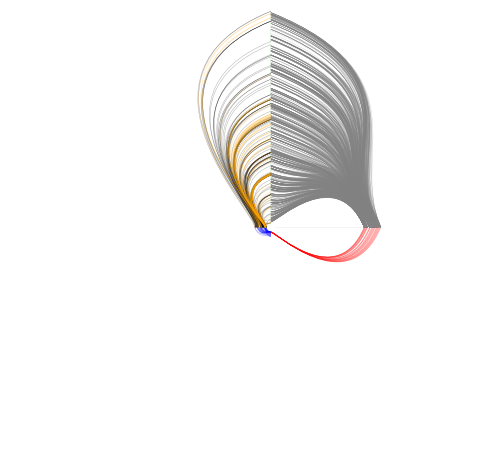

In [267]:
h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()
#plt.savefig('temp.pdf')